In [1]:
# Author: Denis A. Engemann <denis.engemann@gmail.com>
# License: BSD (3-clause)

# Figure 1 (and/or+ Supp Fig) : 

  - exemple of PSD in one subject (displaying 20s epochs)
  - exemple of PSD in one subject (displaying sensors)
  - 1/f for all subjects overlapped in 1 figure (1 line is one subject)
  - psd for all individuals in one or two shots


  - capture and picture variance in figure

We first need to download the requisite data. We are probablt on a "c3.2xlarge" instance, where the storage dir is in /mnt by my own convention.
We also make sure that all auxilliary files are in our working directory.
Depending on the kind of instance this type of downloading can take a moment. Might be worth having a coffee.

In [2]:
import glob
import os.path as op
import mne
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mne.utils.set_log_level('warning')

In [5]:
%%bash
(cp ../*txt . && cp ../*csv .)

In [65]:
%%bash
for sub in $(cat hcp_good_subjects.txt); do
    echo "downloading epochs for ${sub}" 
    python hcp_compute_subject.py --storage_dir /mnt --hcp_no_anat --hcp_no_meg \
    --subject $sub --downloaders "library:downloaders.get_single_trial_psd";
done &> download_output.txt

# Now that we have downloaded everything let's get the stuff into Python.

- What we then need to do in order to get the figures is to first compute grand averages and grand standard deviations per subject. 
- Then we can pick good examples of individual subjects. 
- Then we can compute total grand averages total grand standard deviation.
- Then we can look into 1/f stuff

In [4]:
recordings_path = '/mnt/hcp-meg'
pattern = 'psds-r{run}-0-150-epo.fif'
subjects = glob.glob(op.join(recordings_path, '??????'))

def get_epochs_for_subject(subject):
    epochs_list = list()
    for run_index in range(2):
        psd_fname = op.join(recordings_path, subject, pattern.format(run=run_index))
        if op.isfile(psd_fname):
            epochs = mne.read_epochs(psd_fname)
            if epochs.info['nchan'] == 248:
                epochs_list.append(epochs)
    if epochs_list:
        epochs = mne.epochs.concatenate_epochs(epochs_list)
    else:
        epochs = None
    return epochs

# mean first or log first?

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

epochs = get_epochs_for_subject(subjects[0])
X_std = np.log10(epochs.standard_error().data)
X2_std = np.log10(epochs.get_data()).std(0)
X = np.log10(epochs.average().data)
X2 = np.log10(epochs.get_data()).mean(0)

# multitaper does subsample, our actual frange is:
freqs = np.log10(np.linspace(0.001, 127, len(epochs.times)))

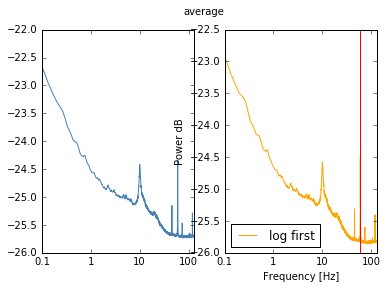

In [6]:
fig, axes = plt.subplots(1, 2, sharex=True)
plt.suptitle('average')
axes[0].plot(freqs, X.mean(0), color='steelblue', label='average first')
axes[1].plot(freqs, X2.mean(0), color='orange', label='log first')
plt.axvline(np.log10(60), color='red')
plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
plt.xlim(np.log10([0.1, 130]))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power dB')
plt.legend(loc='lower left')

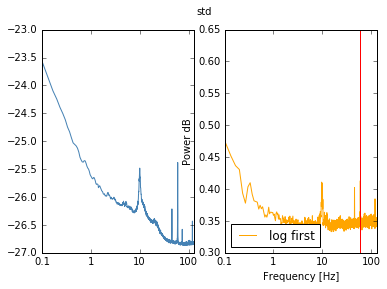

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True)
plt.suptitle('std')
freqs = np.log10(np.linspace(0.001, 127, len(epochs.times)))
axes[0].plot(freqs, X_std.mean(0), color='steelblue', label='average first')
axes[1].plot(freqs, X2_std.mean(0), color='orange', label='log first')
plt.axvline(np.log10(60), color='red')
plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
plt.xlim(np.log10([0.1, 130]))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power dB')
plt.legend(loc='lower left')

_Clearly, we want to first log, then aveage!_

In [13]:
# summarize our subjects
averages_std = list()
averages_mean = list()
subjects_psds = list()
for subject in subjects:
    if subject in subjects_psds:
        continue
    try:
        epochs = get_epochs_for_subject(subject)
    except:
        print('Error finding data for %s. Consider downloading them once more.' % subject)
        continue
    if epochs is None:
        print('Cannot find data for %s' % subject)
        continue
    subjects_psds.append(subject)
    epochs._data = np.log10(epochs._data)
    averages_std.append(epochs.standard_error())
    averages_mean.append(epochs.average());

Cannot find data for /mnt/hcp-meg/149741
Cannot find data for /mnt/hcp-meg/735148
Cannot find data for /mnt/hcp-meg/568963
Cannot find data for /mnt/hcp-meg/181232
Cannot find data for /mnt/hcp-meg/104012
Cannot find data for /mnt/hcp-meg/205119
Cannot find data for /mnt/hcp-meg/187547
Cannot find data for /mnt/hcp-meg/109123
Cannot find data for /mnt/hcp-meg/352738
Cannot find data for /mnt/hcp-meg/223929
Cannot find data for /mnt/hcp-meg/248339
Cannot find data for /mnt/hcp-meg/353740
Cannot find data for /mnt/hcp-meg/725751
Cannot find data for /mnt/hcp-meg/146129
Cannot find data for /mnt/hcp-meg/667056
Error finding data for /mnt/hcp-meg/212823. Consider downloading them once more.
Cannot find data for /mnt/hcp-meg/102816
Cannot find data for /mnt/hcp-meg/175237
Error finding data for /mnt/hcp-meg/204521. Consider downloading them once more.
Cannot find data for /mnt/hcp-meg/112920


In [14]:
from scipy.stats import trim_mean

def tmean(X):
    return trim_mean(X, proportiontocut=0.1, axis=0)

viz_agg = dict(
    mean_mean=tmean([evoked.data for evoked in averages_mean]),
    std_mean=tmean([evoked.data for evoked in averages_std]),
    mean_std=np.std([evoked.data for evoked in averages_mean], axis=0),
    std_std=np.std([evoked.data for evoked in averages_std], axis=0))


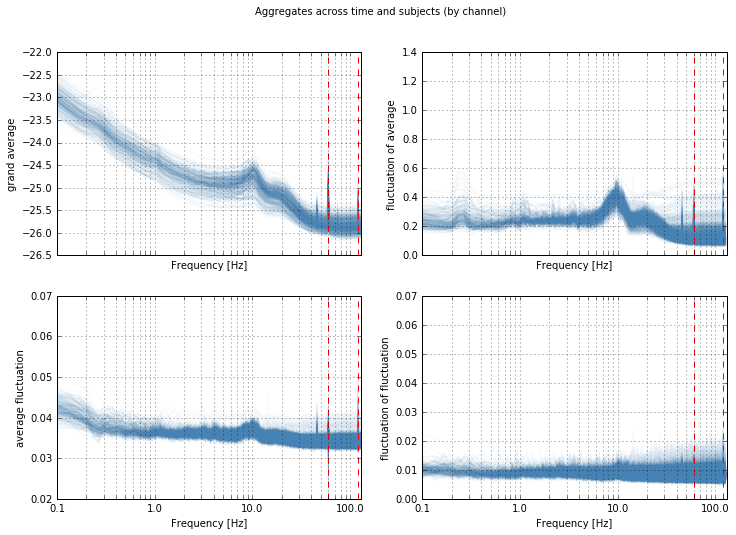

In [190]:
log_range = np.array(np.r_[np.arange(0.1, 1.1, 0.1), np.arange(2, 11, 1), np.arange(20, 110, 10)])
ticks_range = [tt if tt in [0.1, 1, 10, 100] else '' for tt in log_range]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
fig.suptitle('Aggregates across time and subjects (by channel)')
keys = 'mean_mean', 'mean_std', 'std_mean', 'std_std'
for ii, (ax, key) in enumerate(zip(axes.ravel(), keys)):
    ax.plot(freqs, viz_agg[key].T, color='steelblue', alpha=0.05)
    ax.grid(zorder=1)
    for line in np.log10([60, 120]):
        ax.axvline(line, color='red', linestyle='--')
    ax.set_xticks(np.log10(log_range))
    ax.set_xticklabels(ticks_range)
    ax.set_xlim(np.log10([0.1, 130]))
    ax.set_xlabel('Frequency [Hz]')
    if key == 'mean_mean':
        ax.set_ylabel('grand average')
    elif key == 'mean_std':
        ax.set_ylabel('fluctuation of average')
    elif key == 'std_mean':
        ax.set_ylabel('average fluctuation')
    elif key == 'std_std':
        ax.set_ylabel('fluctuation of fluctuation')         

Interestingly we see variability in alpha with any of the four aggregations.

In [17]:
viz_agg_subjects = dict(
    mean_mean=np.array([tmean(evoked.data) for evoked in averages_mean]),
    std_mean=np.array([tmean(evoked.data) for evoked in averages_std]),
    mean_std=np.array([evoked.data.std(0) for evoked in averages_mean]),
    std_std=np.array([evoked.data.std(0) for evoked in averages_std]))


In [18]:
print(viz_agg_subjects['mean_mean'].shape)

(70, 3815)


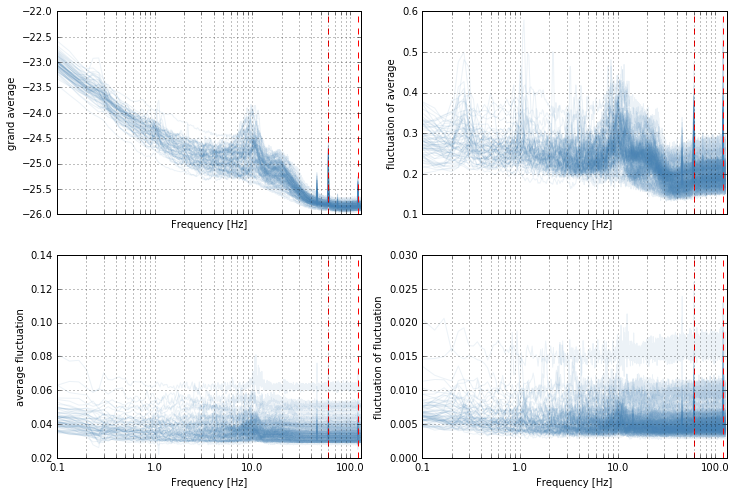

In [189]:
fix, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
fig.suptitle('Aggregates across time and channel (by subject)')
keys = 'mean_mean', 'mean_std', 'std_mean', 'std_std'
for ii, (ax, key) in enumerate(zip(axes.ravel(), keys)):
    ax.grid(True, zorder=0)
    ax.plot(freqs, viz_agg_subjects[key].T, color='steelblue', alpha=0.1)
    for line in np.log10([60, 120]):
        ax.axvline(line, color='red', linestyle='--')
    ax.set_xticks(np.log10(log_range))
    ax.set_xticklabels(ticks_range)
    ax.set_xlim(np.log10([0.1, 130]))
    ax.set_xlabel('Frequency [Hz]')
    if key == 'mean_mean':
        ax.set_ylabel('grand average')
    elif key == 'mean_std':
        ax.set_ylabel('fluctuation of average')
    elif key == 'std_mean':
        ax.set_ylabel('average fluctuation')
    elif key == 'std_std':
        ax.set_ylabel('fluctuation of fluctuation')


A similar pattern occurs when looking at the subject's distributions of cross-channel and cross-trial aggregates. We also see that some subjects fluctuate globally more than others. Noise? We might need to standardize or use robust stats.

# 1/f estimation with residual or covariate analysis.

One particular problem of the correlation analysis between 1/f estimates and alpha power is related to the model fit. In other words what could drive the oscillations is not changes in 1/f per se but oscillations and low frequency fluctuations. To disentengle these contributing factors we propose to explicitly model both aspects using a regression model in which the actual 1/f fit and the residuals are taken into account when predicting the alpha power.
One intuitive way of achieving this is a second order regression model in which the coefficients and the model fit, e.g., measured as $R^{2}$ or $MSQ$ score as predictors of alpha. In this context it would be important to consider the dsitribution of the loss metric. Before proceeding let's inspect more closely the distribution of coefficients and errors / the explained variance. Should they be correlated we definitely have an interesting problem.

In [20]:
import numpy as np
import mne

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


def compute_log_linear_fit(psds, freqs, sfmin, sfmax, reg=None, log_fun=None):
    sfmask = mne.utils._time_mask(freqs, sfmin, sfmax)
    x = freqs[sfmask, None]
    if log_fun is not None:
        x = log_fun(x)
    if reg is None:
        reg = LinearRegression()

    coefs = list()
    intercepts = list()
    msq = list()
    r2 = list()
    if log_fun is not None:
        psds = log_fun(psds)
    for i_epoch, this_psd in enumerate(psds):

        Y = this_psd[:, sfmask].T
        reg.fit(x, Y)
        pred = reg.predict(x)
        msq.append(np.array(
            [mean_squared_error(b, a) for a, b in zip(pred.T, Y.T)]))
        r2.append(np.array(
            [r2_score(b, a) for a, b in zip(pred.T, Y.T)]))
        coefs.append(reg.coef_[:, 0])
        intercepts.append(reg.intercept_)

    coefs = np.array(coefs)
    intercepts = np.array(intercepts)
    msq = np.array(msq)
    r2 = np.array(r2)
    return coefs, intercepts, msq, r2


In [21]:
epochs = get_epochs_for_subject(subjects[0])

coefs, intercepts, msq, r2 = compute_log_linear_fit(
    epochs.get_data(), freqs=np.linspace(0.001, 127, len(epochs.times)), sfmin=0.1, sfmax=1.,
    log_fun=np.log10)

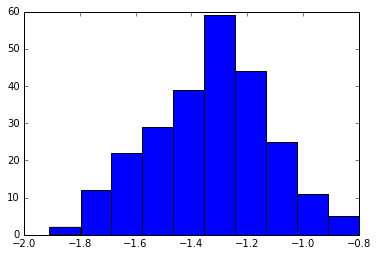

In [138]:
plt.hist(coefs.mean(0));

Nice (log) normal coeffiecients. What does the *fit* say? (NOT https://www.youtube.com/watch?v=jofNR_WkoCE)

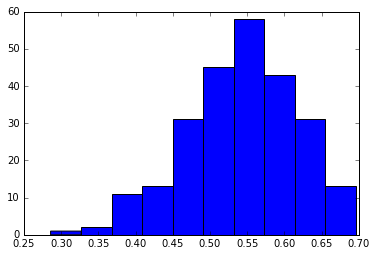

In [140]:
plt.hist(r2.mean(0));

also normalish explained variance... Now mean squared error?

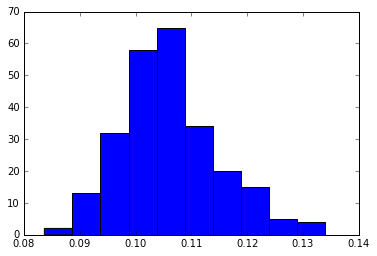

In [141]:
plt.hist(msq.mean(0));

The same, only in the inverted sense. Now let's correlate this stuff.

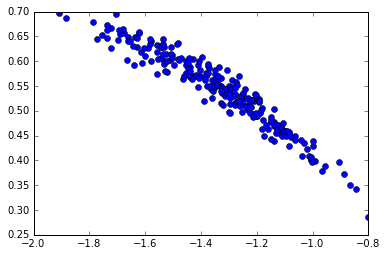

In [142]:
plt.plot(coefs.mean(0), r2.mean(0), marker='o', linestyle='None');

Our fit is correlated with the predicted with the slope. Well think about it. This is either trivial, as bigger coeffients mean more explained variance or it is less trivial as it might indicate that the model fit depends on the slope of the 1/f, which might mean it's not a fluctuation of 1/f per see but of the fit.

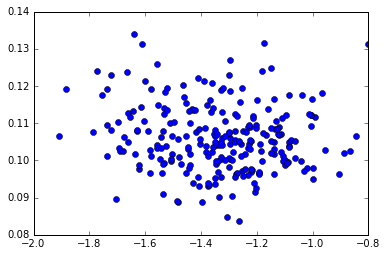

In [149]:
plt.plot(coefs.mean(0), msq.mean(0), marker='o', linestyle='None');

Interestingly the mean squared error is not really correlated with the slope.

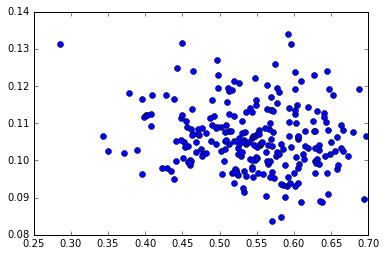

In [150]:
plt.plot(r2.mean(0), msq.mean(0), marker='o', linestyle='None');

Nore the $R2$ and the $MSQ$, making me think more closely how they are related. I assumed a redundant relationship which might not be the case
http://stats.stackexchange.com/questions/32596/what-is-the-difference-between-coefficient-of-determination-and-mean-squared


Time to put things together and scale up a bit. Let's first donwload the frequency labels which are stored in the times numpy file. We forgot to do this earlier. Then let's use our library scripts functions in order to compute 1/f outputs in parallel and store them to the s3 bucket.

In [68]:
%%bash
aws s3 cp s3://hcp-meg-data/hcp-meg/100307/psds-r0-0-150-times.npy /mnt/hcp-meg/100307/ \
    --region us-east-1 && ls -l /mnt/hcp-meg/100307/

download: s3://hcp-meg-data/hcp-meg/100307/psds-r0-0-150-times.npy to ../../../../../mnt/hcp-meg/100307/psds-r0-0-150-times.npy
total 625344
drwxrwxr-x 4 ubuntu ubuntu      4096 Apr 28 22:35 download_only
-rw-rw-r-- 1 ubuntu ubuntu 208176149 Apr 26 20:17 psds-r0-0-150-epo.fif
-rw-rw-r-- 1 ubuntu ubuntu     30600 Apr 26 20:17 psds-r0-0-150-times.npy
-rw-rw-r-- 1 ubuntu ubuntu 242236649 Apr 26 20:17 psds-r1-0-150-epo.fif
-rw-rw-r-- 1 ubuntu ubuntu 189253649 Apr 26 20:17 psds-r2-0-150-epo.fif


In [84]:
%%bash
# python ./run_parallel.py --script  hcp_compute_subject.py --par_args 100307 \
python ./run_parallel.py --script  hcp_compute_subject.py --par_args \ $(cat hcp_good_subjects.txt) \
    --par_target subject --sleep 5 --n_par 6 --args  --storage_dir /mnt \
    --fun_path '~/github/meg_study_dynamic_scales/scripts/library:workflows.compute_log_linear_fit_epochs'\
    --s3 --hcp_no_anat --hcp_no_meg --keep_files &> par_output_lm_fit.txt

In [98]:
%%bash
# check the number of correctly processed subejcts, relying on the standard output when uploading files
cat par_output_lm_fit.txt | grep psds-loglinear-fit-0p1-1.h5 | wc -l;
# check files on local disk
ls /mnt/hcp-meg/*/psds-loglinear-fit-0p1-1.h5 | wc -l

70
70


#### Ok this looks a bit geeky. But it allowed us to conveniently make all the 1/4 stats and upload them to s3. 
#### Now we can analyze 1/f patterns across subjects.

In [100]:
lm_fits = list()
for fname in glob.glob("/mnt/hcp-meg/*/psds-loglinear-fit-0p1-1.h5"):
    lm_fits.append(read_hdf5(fname))

In [244]:
fits_viz_agg_subjects = dict(
    mean_mean=np.array([[lm['coefs'].mean(0), lm['intercepts'].mean(0)] for lm in lm_fits]).mean(2),
    mean_std=np.array([[lm['coefs'].mean(0), lm['intercepts'].mean(0)] for lm in lm_fits]).std(2),
    std_mean=np.array([[lm['coefs'].std(0), lm['intercepts'].std(0)] for lm in lm_fits]).mean(2),
    std_std=np.array([[lm['coefs'].std(0), lm['intercepts'].std(0)] for lm in lm_fits]).std(2)
)
# 

In [220]:
fits_viz_agg_subjects['mean_mean'].shape

(70, 2, 248)

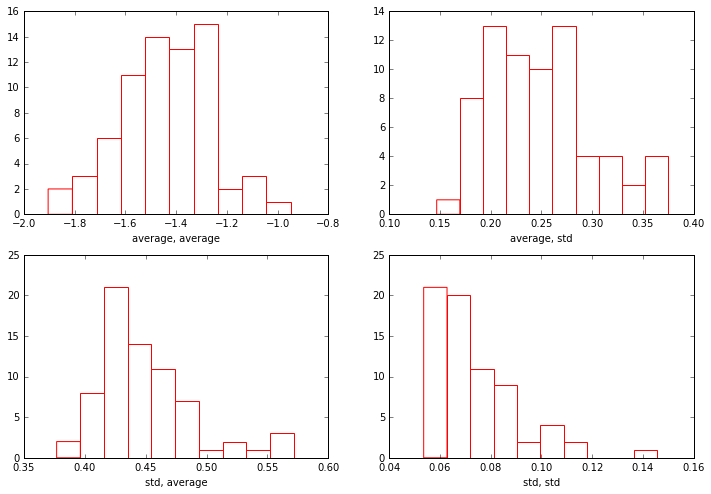

In [253]:
fix, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Aggregates of 1/f across time and channel (by subject)')
keys = 'mean_mean', 'mean_std', 'std_mean', 'std_std'

fits_viz_agg_subjects[key]
for ii, (ax, key) in enumerate(zip(axes.ravel(), keys)):
    ax.hist(fits_viz_agg_subjects[key][:, 0], 10, color='white', edgecolor='red')
    if key == 'mean_mean':
        ax.set_xlabel('average, average')
    elif key == 'mean_std':
        ax.set_xlabel('average, std')
    elif key == 'std_mean':
        ax.set_xlabel('std, average')
    elif key == 'std_std':
        ax.set_xlabel('std, std')

We see that there is a good amount of dispersion of the average 1/f fit across channels (row 1).
Second we see that there is also some good amount of fluctuation over time, interestingly rather globally on an absolute scale (little variation across channels), see row 2.

#### Playing with detrending here reveals a few discomforting facts.

1. The spectra lower to a 2-3 Hz are not really linear, there is a non-linear trend that simply remains when removing a linear fit in the low frequency range that again looks like the naive 1/f . Above the trend is inverse, it looks alltogether like a Nike logo, best semantic approximation of what can be seen, for example see cell below.
2. Going in smaller steps of 0.1 Hz. just removes almost everyting, however a few fluctuations remain. Could be interesting when considered using an envelope.
3. The same is true for frequencies above 30 hz.
4. in between we can work with this for alpha-peak detection and it seems we can this way enhance at least 2 big peaks, namely alpha and beta.

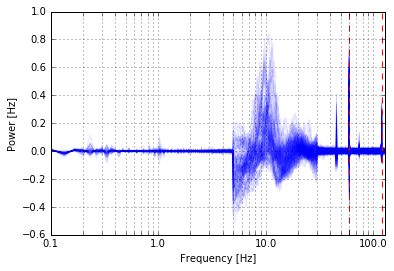

In [415]:
from scipy.signal import detrend
viz_agg_subjects['mean_mean'].shape
orig_freqs = 10 ** freqs
bp = list()
for freq in np.log10(np.r_[np.linspace(0.1, 5), [30], np.linspace(30, 130, 100)]):
    bp.append(np.abs(freqs - freq).argmin())
plt.grid()
plt.plot(freqs, detrend(viz_agg_subjects['mean_mean'], bp=bp).T, color='blue', alpha=0.1)
# plt.plot(freqs, viz_agg_subjects['mean_mean'].T, color='blue', alpha=0.1)
plt.xlim(np.log10([0.1, 130]))
for line in np.log10([60, 120]):
    plt.axvline(line, color='red', linestyle='--')

plt.xticks(np.log10(log_range), ticks_range)
plt.xlabel('Frequency [Hz]');
plt.ylabel('Power [Hz]')

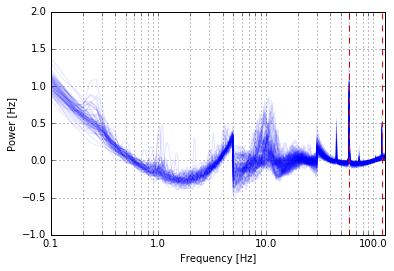

In [525]:
bp = list()
for freq in np.log10(np.r_[5, 30]):
    bp.append(np.abs(freqs - freq).argmin())
plt.grid()
plt.plot(freqs, detrend(viz_agg_subjects['mean_mean'], bp=bp).T, color='blue', alpha=0.1)
# plt.plot(freqs, viz_agg_subjects['mean_mean'].T, color='blue', alpha=0.1)
plt.xlim(np.log10([0.1, 130]))
for line in np.log10([60, 120]):
    plt.axvline(line, color='red', linestyle='--')

plt.xticks(np.log10(log_range), ticks_range)
plt.xlabel('Frequency [Hz]');
plt.ylabel('Power [Hz]');

#### Ok, alltogether room for improvement . Now back to the main business.
Before we leave some concluding notes.

- http://behavioralandbrainfunctions.biomedcentral.com/articles/10.1186/1744-9081-3-62 along these lines it might be better to detrend the time-series using a differentiator approach
- However using a simple differentiator approach on the given power spectrum is pretty much similar to doing local linear detrending with small break point steps. I would then need to think how the 1/f VS non-1/f question could be transplanted there. Probably by using linear fits on the detrended and non detrended signals and combining them in the 2nd order regression model.
- also considere Anne's 2014 NIMG paper:  _"To substantiate a peak neural entrainment at 1 Hz, the 1/f component was re- moved by subtracting at each frequency bin the mean power of the neighboring frequency values (4 frequency values were: [fo − 0.14Hz; fo − 0.07 Hz; fo + 0.07 Hz; fo + 0.14 Hz])"_

5.02901494494
19.9798673309


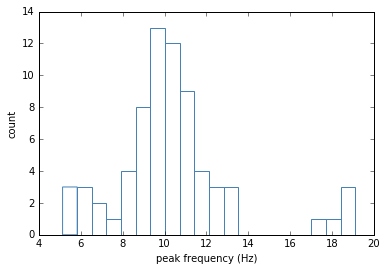

In [716]:
from mne.utils import _time_mask as freq_mask
bp = list()
for freq in np.log10(np.r_[np.linspace(0.1, 5), [30], np.linspace(30, 130, 100)]):
    bp.append(np.abs(freqs - freq).argmin())

# note that `freqs` are already transformed by log10
X = detrend(viz_agg_subjects['mean_mean'], bp=bp)
fmin, fmax = 5, 20
fmask = freq_mask(freqs, np.log10(fmin), np.log10(fmax))
print((10 ** freqs[fmask]).min())
print((10 ** freqs[fmask]).max())
plt.hist([10 ** freqs[fmask][ix] for ix in X[:, fmask].argmax(1)], color='white', edgecolor='steelblue',
         bins=20)
plt.xlabel('peak frequency (Hz)')
plt.ylabel('count');

This graph shows us that for most persons the frequency with the highest amplitdude between 5 and 20 Hz is between 8 and 13 Hz. Also in this range we see something that approximately follows a gaussian distribution. If we now use this distribution to estimate the alpha range we could cut below 8 Hz and above 13 Hz, so no alpha peak was observable for any observation outside this range. We can now correlate these results with the HCP data, after rounding as the HCP only ships integer resolved estimates of the peaks but also give us Nan labeles in cases where classification failed.

In [718]:
# make sure we know who is who
assert len(subjects_psds) == len(X)
subjects_to_look_up = [sub.split('/')[-1] for sub in subjects_psds]
print(subjects_to_look_up[:2])

['257845', '715950']


In [719]:
df = pd.read_csv('hcp_unrestricted_data.csv')

In [720]:
df = df[df['Subject'].astype(str).isin(subjects_to_look_up)]

In [721]:
alpha_map = df.set_index('Subject').Alpha_Peak.to_dict()

In [722]:
fmin, fmax = 8, 13
fmask = freq_mask(freqs, np.log10(fmin), np.log10(fmax))
alphas_hcp = [alpha_map[int(sub)] for sub in subjects_to_look_up]
alphas_me = [round(10 ** freqs[fmask][ix]) for ix in X[:, fmask].argmax(1)]



In [726]:
alphas = np.array([(a1, a2) for a1, a2 in zip(alphas_me, alphas_hcp) if not np.isnan(a2)])

from sklearn.metrics import mean_squared_error, r2_score
print(mean_squared_error(alphas[:, 0], alphas[:, 1]))
print(r2_score(alphas[:, 0], alphas[:, 1]))
print(np.corrcoef(alphas.T))

1.50724637681
0.0347054075868
[[ 1.          0.44756932]
 [ 0.44756932  1.        ]]


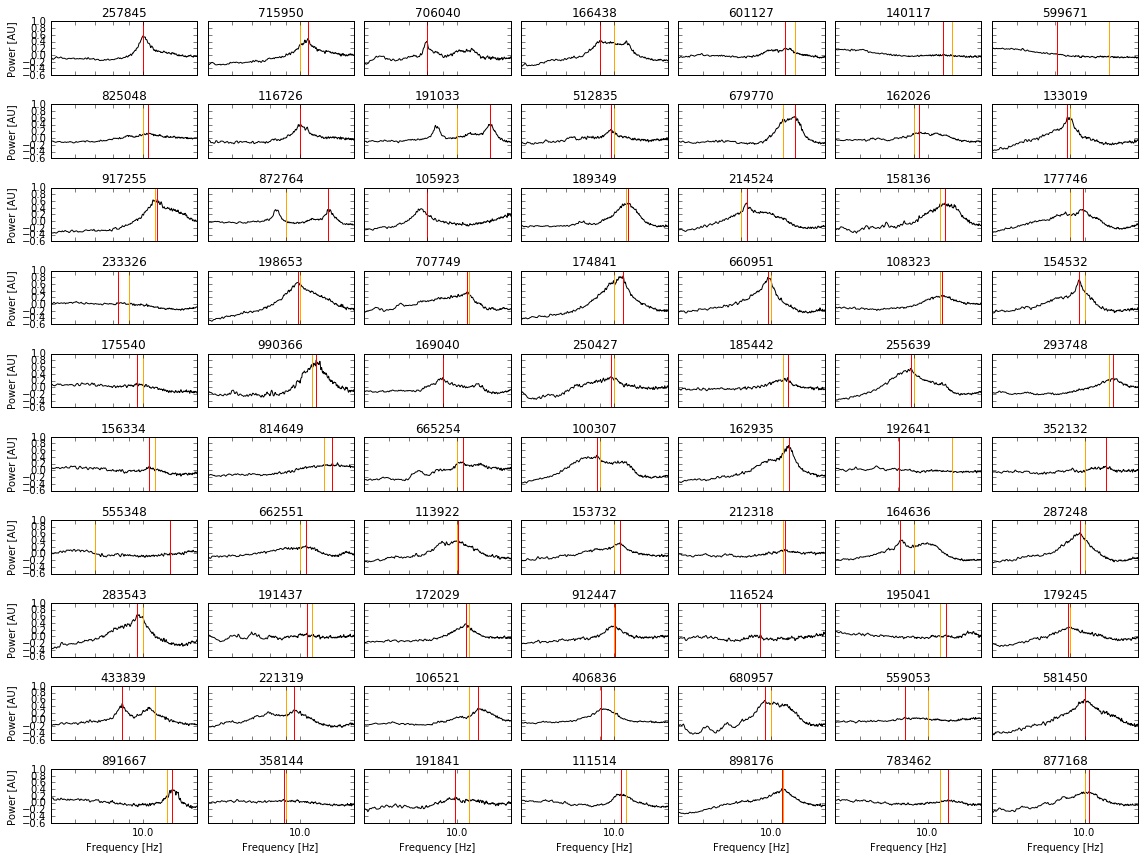

In [727]:
alphas_me = [10 ** freqs[fmask][ix] for ix in X[:, fmask].argmax(1)]

fig, axes = plt.subplots(10, 7, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.ravel()
for ii, ax in enumerate(axes):
    ax.plot(freqs, X[ii], color='black')
    ax.axvline(np.log10(alphas_hcp[ii]), color='orange')
    ax.axvline(np.log10(alphas_me[ii]), color='red')
    ax.set_xticks(np.log10(log_range))
    ax.set_xticklabels(ticks_range) 
    ax.set_xlim(np.log10([5, 15]))
    ax.set_title(subjects_to_look_up[ii])
    if ii in list(range(0, 71, 7)):
        ax.set_ylabel('Power [AU]')
    if ii in list(range(70 - 7, 70, 1)):
        ax.set_xlabel('Frequency [Hz]')
plt.tight_layout()

This figure shows us the HCP (orange) and our (red) estimates of the peak. It is clearly visible that the HCP estimates must be based on different power spectral estimates, on the exact data we are using our estimates are obviously more appropriate.

In [713]:
this_subject = subjects[0].split('/')[3]

In [557]:
epochs = get_epochs_for_subject(this_subject)

In [573]:
lm_fits = dict()
for fname in glob.glob("/mnt/hcp-meg/??????/psds-loglinear-fit-0p1-1.h5"):
    subject = fname.split('/')[3]
    lm_fits[subject] = read_hdf5(fname)

In [728]:
assert lm_fits[this_subject]['coefs'].shape[0] == len(epochs)

In [797]:
info = mne.io.Info(lm_fits[this_subject]['info'])

def get_bti_info(info):
    from mne.viz.topomap import _find_topomap_coords
    picks = list(range(248))
    pos = _find_topomap_coords(info, picks=picks)
    return mne.channels.layout.Layout(
        box=(-42.19, 43.52, -41.7, 28.71), pos=pos, names=[info['ch_names'][idx] for idx in picks], ids=picks,
        kind='magnesWH3600_hcp')

In [798]:
lout = get_bti_info(info)

In [824]:
def plot_topomap(inst, points, unit, cmap='magma', **kwargs):
    return inst.plot_topomap(
        points, scale=1, size=2, vmin=np.min, vmax=np.max, cmap=cmap,
        contours=0, scale_time=1, time_format='%0.2fHZ', layout=lout, unit=unit, **kwargs);

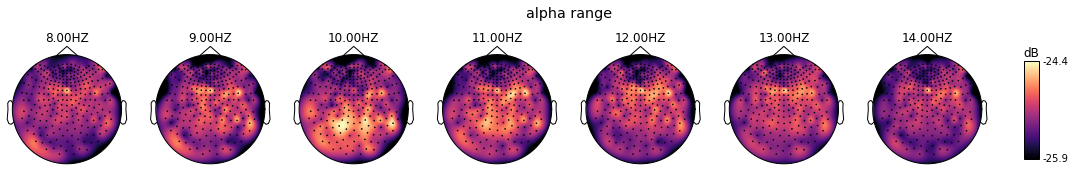

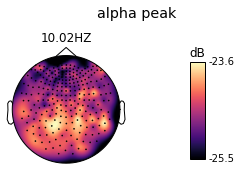

In [825]:
coefs = lm_fits[this_subject]['coefs']
mse = lm_fits[this_subject]['msq']
peak_idx = np.abs(freqs - alphas_me[0]).argmax()

this_X = np.log10(epochs.get_data())

mne_this_X = mne.EvokedArray(this_X.mean(0), info=info, tmin=0)
mne_this_X.times = 10 ** freqs[:]

plot_topomap(mne_this_X, [8, 9, 10, 11, 12, 13, 14], unit='dB', title='alpha range');
plot_topomap(mne_this_X, alphas_me[:1], unit='dB', title='alpha peak');


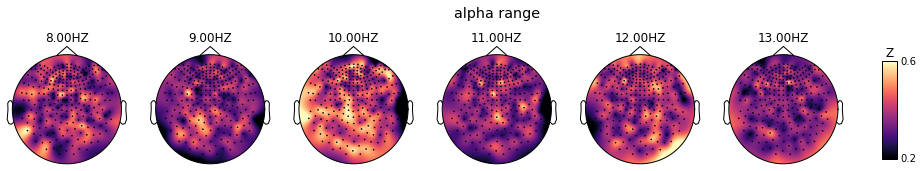

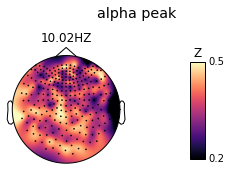

In [826]:
mne_this_X = mne.EvokedArray(this_X.std(0), info=info, tmin=0)
mne_this_X.times = 10 ** freqs[:]
plot_topomap(mne_this_X, [8, 9, 10, 11, 12, 13], unit='Z', title='alpha range (std)');
plot_topomap(mne_this_X, alphas_me[:1], unit='Z', title='alpha peak (std)');

Obeservation: the variance patterns across time don't look as nice as one might hope. The patterns do not look very physiological. Intuitively this might be related to the fact that we're pooling across 3 runs without motion correction. It should look better when only considering a few time segments.

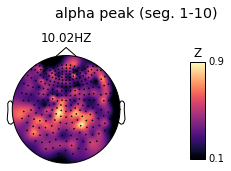

In [827]:
mne_this_X = mne.EvokedArray(this_X[:10].std(0), info=info, tmin=0)
mne_this_X.times = 10 ** freqs[:]
plot_topomap(mne_this_X, alphas_me[:1], unit='Z', title='alpha peak (seg. 1-10)');

Indeed it looks a bit more as I would have expected. To be kept in mind. Time to look at the coefficients.

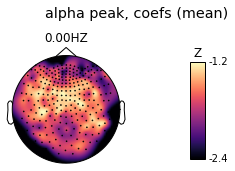

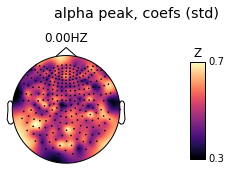

In [828]:
coefs_mne = mne.EvokedArray(coefs.mean(0, keepdims=True).T, info=info, tmin=0)

plot_topomap(coefs_mne, [0], unit='Z', title='alpha peak, coefs (mean)');
coefs_mne = mne.EvokedArray(coefs.std(0, keepdims=True).T, info=info, tmin=0)

plot_topomap(coefs_mne, [0], unit='Z', title='alpha peak, coefs (std)');

We see a more central pattern for the mean, spatially smoothly correlated. Less so for std. What does the error look like?

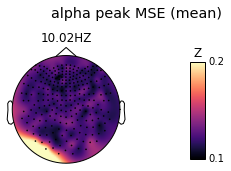

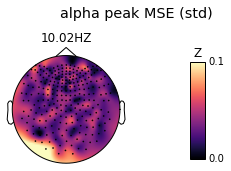

In [832]:
mse_mne = mne.EvokedArray(mse.mean(0, keepdims=True).T, info=info, tmin=0)
mse_mne.times[:] = alphas_me[0]
plot_topomap(mse_mne, alphas_me[:1], unit='Z', title='alpha peak MSE (mean)');
mse_mne = mne.EvokedArray(mse.std(0, keepdims=True).T, info=info, tmin=0)
mse_mne.times[:] = alphas_me[0]
plot_topomap(mse_mne, alphas_me[:1], unit='Z', title='alpha peak MSE (std)');

This looks artifact driven, lower left edge. Time for some correlations.

In [833]:
from library.stats import compute_corr
from sklearn.decomposition import PCA

peak_ind = np.min(np.log10(freqs) - alphas_me[0]).argmax()
Xb = this_X[..., peak_ind].T
# Xb = np.array([PCA(3).fit_transform(Xb[:, idx, :])[:, 0] for idx in range(248)])}

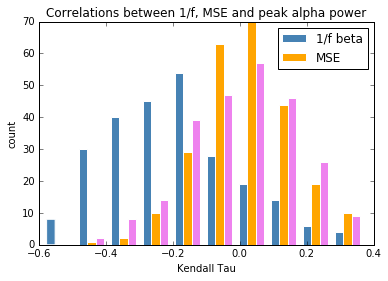

In [857]:
from scipy.stats import kendalltau, pearsonr

plt.figure()
Kt_coefs = np.array([pearsonr(x, y)[0] for x, y in zip(coefs.T, Xb)])
Kt_mse = np.array([pearsonr(x, y)[0] for x, y in zip(mse.T, Xb)])
Kt_mse_coef = np.array([pearsonr(x, y)[0] for x, y in zip(mse.T, coefs.T)])


plt.hist([Kt_coefs, Kt_mse, Kt_mse_coef], color=['steelblue', 'orange', 'violet'], edgecolor='white', label=['1/f beta', 'MSE'])
plt.legend(loc='best')
plt.xlabel('Kendall Tau')
plt.ylabel('count')
plt.title('Correlations between 1/f, MSE and peak alpha power');

*Interesting observation*: more negative correlations between 1/f and alpha occur, more positive ones for MSE. Note that the distribution of correlations between the error and the and the beta follows the correlation between error and alpha.

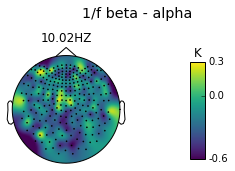

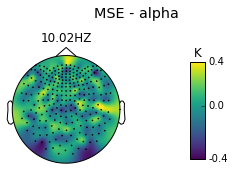

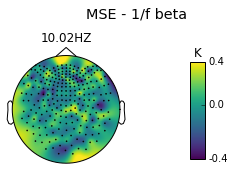

In [858]:
Kt_mne = mne.EvokedArray(Kt_coefs[:, None], info=info, tmin=0)
Kt_mne.times[:] = alphas_me[:1]
plot_topomap(Kt_mne, alphas_me[:1], title='1/f beta - alpha', unit='K', cmap='viridis');
Kt_mne = mne.EvokedArray(Kt_mse[:, None], info=info, tmin=0)
Kt_mne.times[:] = alphas_me[:1]
plot_topomap(Kt_mne, alphas_me[:1], title='MSE - alpha', unit='K', cmap='viridis');
Kt_mne = mne.EvokedArray(Kt_mse_coef[:, None], info=info, tmin=0)
Kt_mne.times[:] = alphas_me[:1]
plot_topomap(Kt_mne, alphas_me[:1], title='MSE - 1/f beta', unit='K', cmap='viridis');

Again lots of noise, but we see some complementary behavior in visual/parietal regions.

## Time to look at a group of subjects

1. put together things from above to make it scalable for cross-subject analyses. We will write a function therefore that returns all the data for each subject and facilitates looping
2. average, aggregate plot.
3. quantify.

In [ ]:
def get_correlations(subject, freqs, peak, coefs, mse):
    epochs = get_epochs_for_subject(subject)
    epochs._data = np.log10(epochs._data)
    peak_index = np.abs(freqs - peak).argmin()
    Xb = epochs.get_data()[..., peak_index]
    fmin, fmax = 8, 13
    fmask = freq_mask(freqs, np.log10(fmin), np.log10(fmax))
    corrs = dict(
        Kt_coefs = np.array([kendalltau(x, y)[0] for x, y in zip(coefs.T, Xb)])
        Kt_mse = np.array([kendalltau(x, y)[0] for x, y in zip(mse.T, Xb)])
        Kt_mse_coef = np.array([kendalltau(x, y)[0] for x, y in zip(mse.T, coefs.T)])
    )
    